In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/severstal-steel-defect-detection/sample_submission.csv
/kaggle/input/severstal-steel-defect-detection/train.csv
/kaggle/input/severstal-steel-defect-detection/train_images/f1bd3a48a.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/55042415c.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/1dba99dc5.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/636700b91.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/e865201fb.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/cbb659739.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/1849f8952.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/e7a980a8f.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/50fb57a6c.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/2f8a16cc3.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/94a3786cb.jpg
/kaggle/input/severstal-steel-defect-detection/train_images/

In [5]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import albumentations as A
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [6]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [7]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5)) 
        form = {'family': 'serif', 'color': 'blue', 'size': 25} 
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')        
        plt.show()

In [8]:
imgdir=r'/kaggle/input/severstal-steel-defect-detection/train_images'
df=pd.read_csv(r'/kaggle/input/severstal-steel-defect-detection/train.csv')
df=df.drop('EncodedPixels', axis=1)
df.columns=['filepaths', 'labels']
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(imgdir,x))
df['labels'] =df['labels'].apply(lambda x: str(x))
print(df.head())

                                                                   filepaths  \
0  /kaggle/input/severstal-steel-defect-detection/train_images/0002cc93b.jpg   
1  /kaggle/input/severstal-steel-defect-detection/train_images/0007a71bf.jpg   
2  /kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg   
3  /kaggle/input/severstal-steel-defect-detection/train_images/000f6bf48.jpg   
4  /kaggle/input/severstal-steel-defect-detection/train_images/0014fce06.jpg   

  labels  
0      1  
1      3  
2      1  
3      4  
4      3  


In [9]:
def image_eval(imgdir):
    flist=sorted(os.listdir(imgdir))
    wt=0
    ht=0
    total_images=0
    for f in tqdm(flist, ncols=120, colour='blue', unit='files'):
        fpath=os.path.join(imgdir,f)
        img=cv2.imread(fpath)
        ht +=img.shape[0]
        wt +=img.shape[1]
        total_images +=1
    wave=int(wt/total_images)
    have=int(ht/total_images)
    print('average images height= ', have, '  average image width= ', wave)
    return 
imgdir=r'/kaggle/input/severstal-steel-defect-detection/train_images'
image_eval(imgdir)

100%|█████████████████████████████████████████████████████████████████████████| 12568/12568 [01:18<00:00, 160.17files/s]

average images height=  256   average image width=  1600


In [10]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    return train_df, test_df, valid_df    

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  5676   test_df length:  710   valid_df length:  709


3    4120
1     718
4     641
2     197
Name: labels, dtype: int64


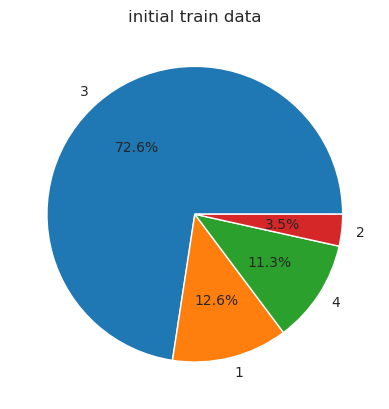

In [11]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train data'
def plot_label_count(df, plot_title):
    labels = df.labels.value_counts()
    fig, ax = plt.subplots()
    ax.pie(labels.values, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(plot_title)
    plt.show()
plot_label_count (train_df, plot_title)

In [12]:

def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
#     print ('Dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('After trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=1000
min_samples= 197
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

After trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  197
the trimmed dataframe now is of length  2556  with  4  classes


In [13]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#     print('Length of augmented dataframe is now ', len(df))
    return df 

n=1000
working_dir=r'/kaggle/working/'
img_size = (100,625)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  2556


augmenting class 2: 100%|██████████████████████████████████████████████████████████| 803/803 [00:11<00:00, 68.13files/s]

Total Augmented images created=  1444


1    1000
3    1000
4    1000
2    1000
Name: labels, dtype: int64


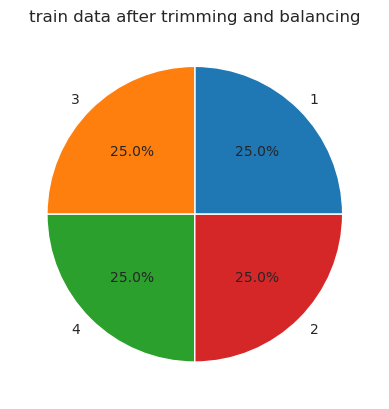

In [14]:
count=train_df['labels'].value_counts()
print (count)
plot_title='train data after trimming and balancing'
def plot_label_count(df, plot_title):
    labels = df.labels.value_counts()
    fig, ax = plt.subplots()
    ax.pie(labels.values, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(plot_title)
    plt.show()
plot_label_count (train_df, plot_title)

In [15]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=30
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 4000 validated image filenames belonging to 4 classes.           for train generator 
Found 709 validated image filenames belonging to 4 classes.            for valid generator 
Found 710 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  71   test steps:  10  number of classes :  4


In [17]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr)

Created EfficientNet B3 model with initial learning rate set to 0.001



In [19]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground



In [20]:
epochs=50
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [21]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/50


2023-04-17 10:11:32.125899: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


134/134 [==============================] - ETA: 0s - loss: 7.1571 - accuracy: 0.7175 - F1_score: 0.7105 - auc: 0.8997
 validation loss of  6.3380 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

134/134 [==============================] - 155s 718ms/step - loss: 7.1571 - accuracy: 0.7175 - F1_score: 0.7105 - auc: 0.8997 - val_loss: 6.3380 - val_accuracy: 0.7193 - val_F1_score: 0.7182 - val_auc: 0.8687
Epoch 2/50
134/134 [==============================] - ETA: 0s - loss: 4.8689 - accuracy: 0.8685 - F1_score: 0.8615 - auc: 0.9663
 validation loss of  4.5261 is 28.5874 % below lowest loss, saving weights from epoch 2   as best weights

134/134 [==============================] - 93s 690ms/step - loss: 4.8689 - accuracy: 0.8685 - F1_score: 0.8615 - auc: 0.9663 - val_loss: 4.5261 - val_accuracy: 0.7673 - val_F1_score: 0.7422 - val_auc: 0.9149
Epoch 3/50
134/134 [==============================] - ETA: 0s - loss: 3.6905 - accuracy: 0.8903 - F1_score: 0.8874 - auc: 

  5


User comment: 5


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 10


you entered 10 Training will continue to epoch 15

134/134 [==============================] - 207s 2s/step - loss: 2.1973 - accuracy: 0.9240 - F1_score: 0.9212 - auc: 0.9868 - val_loss: 2.1098 - val_accuracy: 0.8604 - val_F1_score: 0.8582 - val_auc: 0.9603
Epoch 6/50
134/134 [==============================] - ETA: 0s - loss: 1.7074 - accuracy: 0.9420 - F1_score: 0.9406 - auc: 0.9897
 validation loss of  1.6807 is 20.3399 % below lowest loss, saving weights from epoch 6   as best weights

134/134 [==============================] - 93s 691ms/step - loss: 1.7074 - accuracy: 0.9420 - F1_score: 0.9406 - auc: 0.9897 - val_loss: 1.6807 - val_accuracy: 0.8674 - val_F1_score: 0.8636 - val_auc: 0.9658
Epoch 7/50
134/134 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.9375 - F1_score: 0.9353 - auc: 0.9916
 validation loss of  1.4374 is 14.4709 % below lowest loss, saving weights from epoch 7   as best weights

134/134 [==============================] - 93s 692ms/step - los

  h


User comment: h


 Enter H to end training or  an integer for the number of additional epochs to run then ask again



 h


you entered h,  Training halted on epoch 15 due to user input


134/134 [==============================] - 98s 728ms/step - loss: 0.3268 - accuracy: 0.9630 - F1_score: 0.9632 - auc: 0.9969 - val_loss: 0.6846 - val_accuracy: 0.8618 - val_F1_score: 0.8570 - val_auc: 0.9423
loading model with weights from epoch 15

training elapsed time was 0.0 hours, 26.0 minutes, 15.76 seconds)



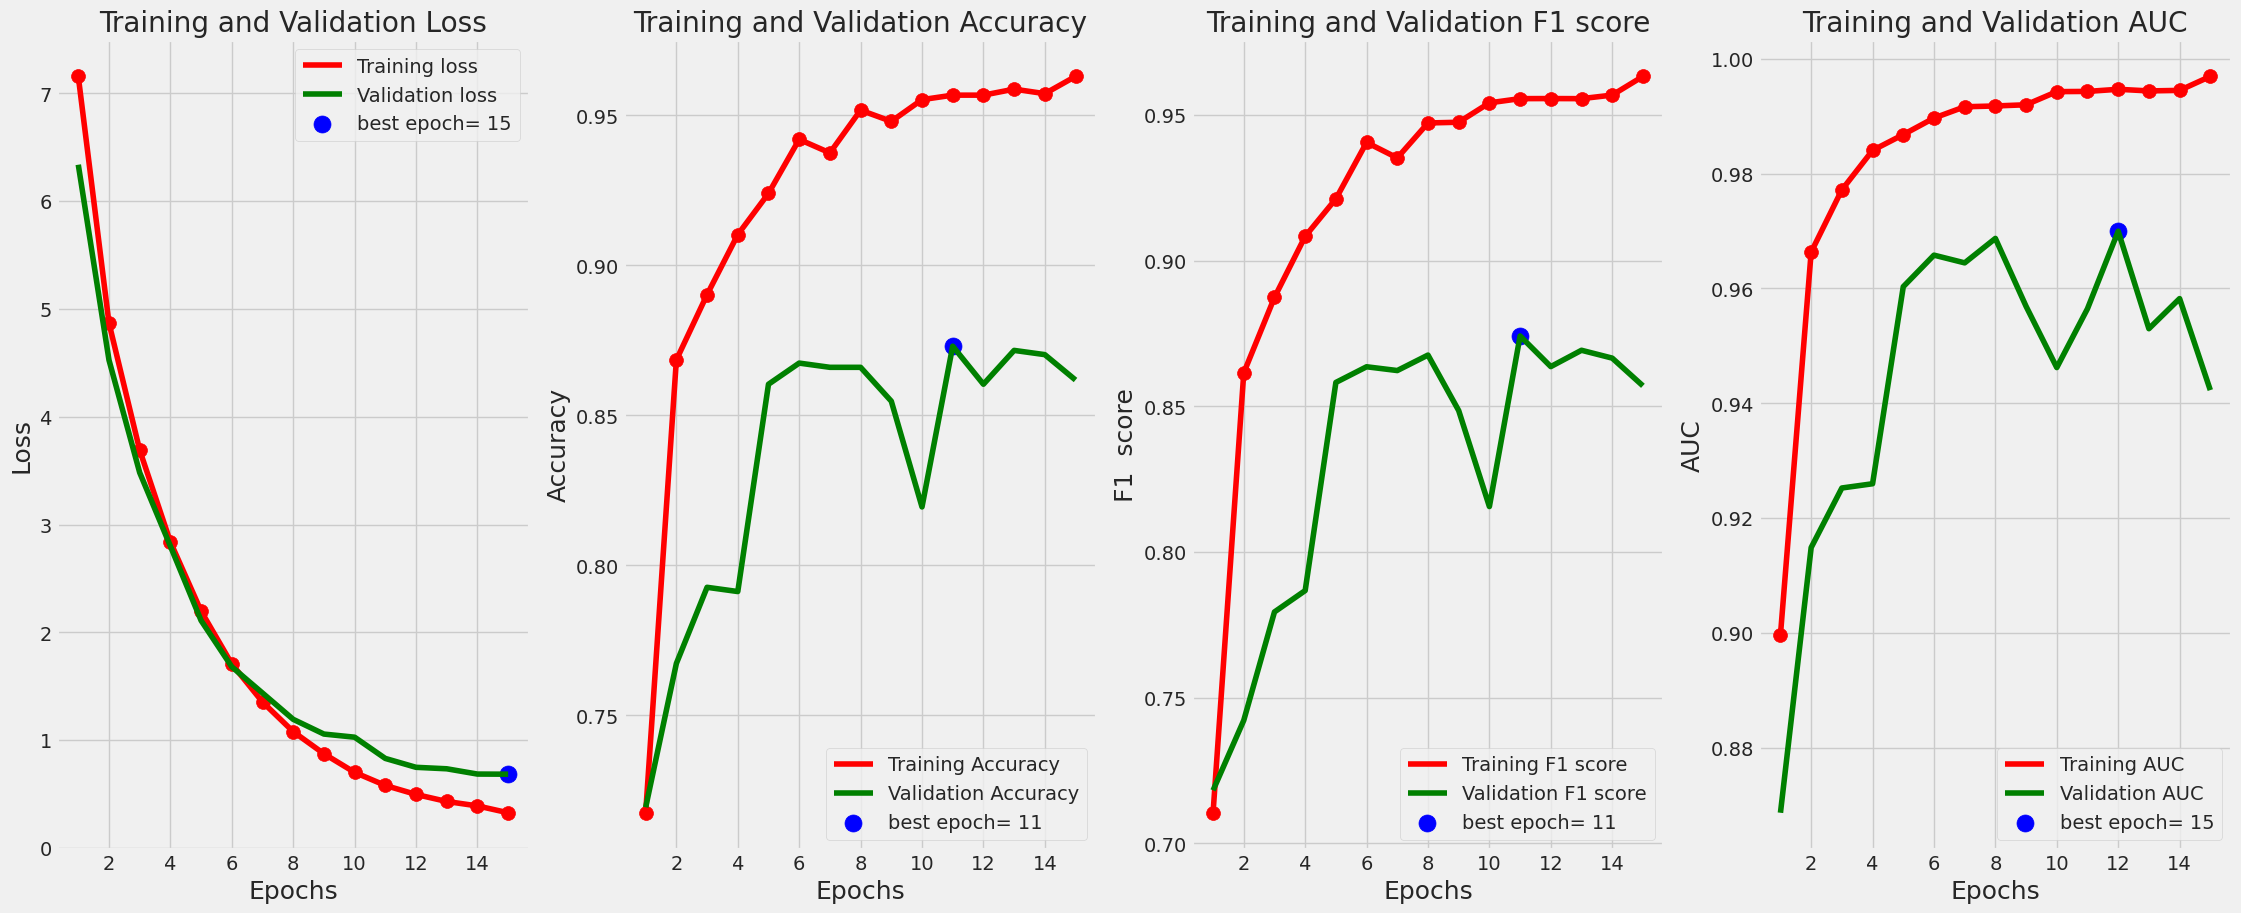

In [22]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']
    tauc=tr_data.history['auc']
    vauc=tr_data.history['val_auc']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    auc_index=np.argmax(vauc)
    val_highest_auc=vauc[auc_index]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    auc_label='best epoch= ' + str(auc_index + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()
    axes[3].plot(Epochs,tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs,vauc,'g',label='Validation AUC' )
    axes[3].scatter(auc_index+1 +start_epoch,val_highest_auc, s=150, c= 'blue', label=sc_label)
    axes[3].scatter(Epochs, tauc, s=100, c='red')    
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()
    plt.tight_layout    
    plt.show()
    return 
    
tr_plot(history)

10/10 [==============================] - 12s 659ms/step
there were 102 errors in 710 tests for an accuracy of  85.63



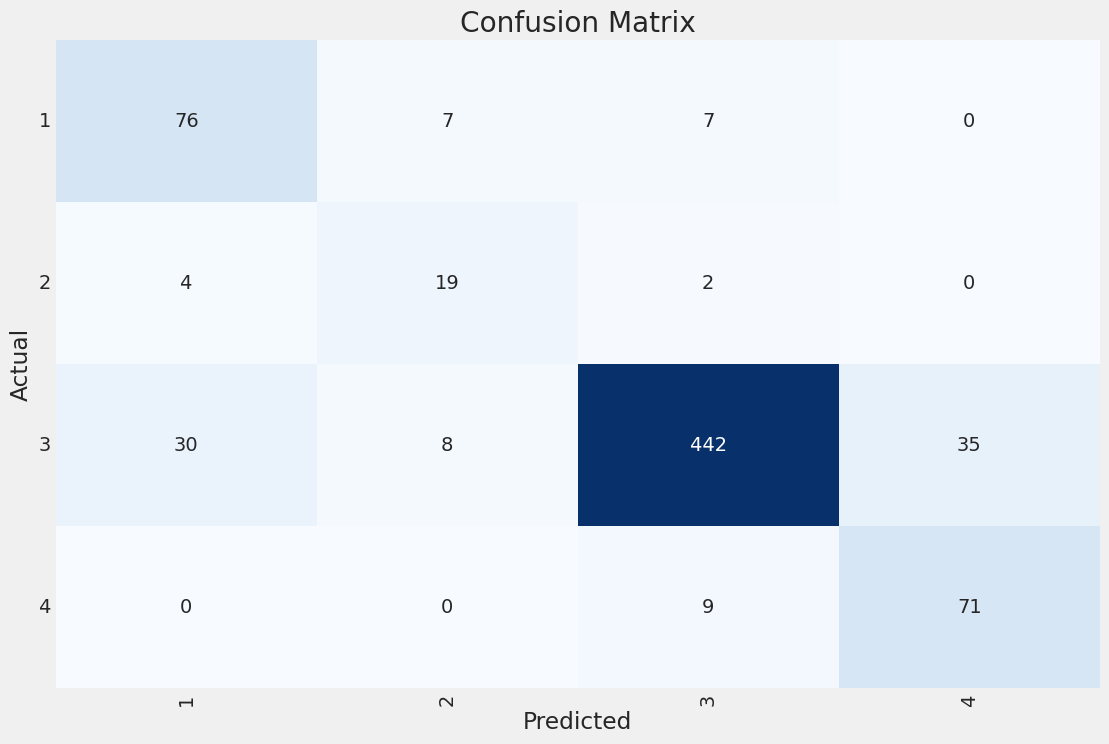

Classification Report:
----------------------
               precision    recall  f1-score   support

           1     0.6909    0.8444    0.7600        90
           2     0.5588    0.7600    0.6441        25
           3     0.9609    0.8583    0.9067       515
           4     0.6698    0.8875    0.7634        80

    accuracy                         0.8563       710
   macro avg     0.7201    0.8375    0.7685       710
weighted avg     0.8797    0.8563    0.8627       710



In [23]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [27]:
def make_test_gen(testdir, img_size):
    flist=sorted(os.listdir(testdir))
    filepaths=[]
    for f in tqdm(flist, ncols=120, colour='blue', unit='files'):
        fpath=os.path.join(testdir,f)
        filepaths.append(fpath)
    Fseries=pd.Series(filepaths, name='filepaths')
    df=pd.concat([Fseries], axis=1)    
    gen=ImageDataGenerator()
    test_gen=gen.flow_from_dataframe(df, x_col='filepaths', y_col=None, class_mode=None, target_size=img_size, shuffle=False)
    return test_gen

testdir=r'/kaggle/input/severstal-steel-defect-detection/test_images'
test_gen= make_test_gen(testdir, img_size)

100%|████████████████████████████████████████████████████████████████████████| 5506/5506 [00:00<00:00, 505103.52files/s]


Found 5506 validated image filenames.


In [28]:
preds= model.predict(test_gen, verbose=1)
print(preds.shape)

173/173 [==============================] - 90s 491ms/step
(5506, 4)


In [29]:
files=[]
dummy=[]
klasses=[]
for i, p in enumerate(preds):
    index=np.argmax(p)    
    klass= int(classes[index])
    klasses.append(klass)    
    file=os.path.basename(test_gen.filenames[i])
    files.append(file)
    dummy.append('1 409600')
Fseries=pd.Series(files, name='ImageId')
Dseries=pd.Series(dummy, name='EncodedPix')
Lseries=pd.Series(klasses, name='ClassId')
submission_df=pd.concat([Fseries, Dseries, Lseries], axis=1)
csvpath= os.path.join(working_dir, 'Test_Predictions.csv')
submission_df.to_csv(csvpath, index=False)
df=pd.read_csv(csvpath)
print (df.head())

         ImageId EncodedPix  ClassId
0  0000f269f.jpg   1 409600        4
1  000ccc2ac.jpg   1 409600        1
2  002451917.jpg   1 409600        4
3  003c5da97.jpg   1 409600        4
4  0042e163f.jpg   1 409600        4
